 # 单因子分析：规模因子 (Size Factor)

**目标**: 本 Notebook 旨在演示如何使用本框架对一个因子进行完整的回测与分析。

**核心思想**: 我们将遵循《因子投资：方法与实践》中定义的标准因子测试流程。该流程的核心是：
1.  **数据准备**: 加载并清洗干净的股票行情与财务数据。
2.  **因子计算**: 计算我们感兴趣的因子——在这里是规模因子（对数市值）。
3.  **分组回测**: 在每个时间点，根据因子值将所有股票排序并分为N组（例如5组），然后观察每组的未来收益表现。
4.  **业绩分析**: 通过多空组合（做多因子值最高组，做空因子值最低组）的净值曲线、年化收益、夏普比率等指标来评估因子的有效性。

In [1]:
# -- 步骤 0: 导入必要的库并设置项目路径 --
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

# 设置matplotlib以支持中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  

# 将项目根目录添加到Python的模块搜索路径中
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
    
# 从项目中导入我们需要的模块
from data_manager.loader import load_and_clean_data
from factor_library.fundamental.size_factor import SizeFactor
from backtest_engine.engine import BacktestEngine
from backtest_engine.performance import PerformanceAnalyzer

print(f"项目根目录已设置为: {project_root}")

项目根目录已设置为: /Users/nachuanchen/Documents/Undergrad_Resources/投资学/Factor_strategy_platform


### 步骤 1: 加载并清洗数据
我们首先调用 `data_manager` 模块中的 `load_and_clean_data` 函数来获取一个干净、对齐的 `master_data` 数据框。这是所有因子计算的基础。

In [2]:
DATA_DIR_PATH = os.path.join(project_root, "data_manager", "DemoData")

master_df, index_df = load_and_clean_data(DATA_DIR_PATH)

if master_df is not None:
    print("\n主数据加载成功，预览:")
    display(master_df.head())

开始执行数据加载与清洗任务...

[步骤 1/4] 正在加载CSV文件...
所有CSV文件加载成功！

[步骤 2/4] 正在进行数据预处理...
 -> 行情数据处理完成，已计算后复权价。
 -> 财务数据处理完成。
 -> 指数数据处理完成。

[步骤 3/4] 正在合并行情与财务数据...
行情与财务数据合并成功！

[步骤 4/4] 正在进行最终清洗...
 -> 已对财务数据进行缩尾处理。

数据加载与清洗任务完成！

主数据加载成功，预览:


open   high    low  close   adjfactor       volume  \
date       stock_code                                                        
2024-01-02 000001.SZ    9.39   9.42   9.21   9.21   71.643514  115836645.0   
           000002.SZ   10.44  10.48  10.15  10.15  181.703787   81110629.0   
           000004.SZ   16.10  16.44  16.05  16.14    4.063862    2886700.0   
           000005.SZ    1.08   1.12   1.08   1.12    9.267603    6302800.0   
           000006.SZ    4.58   4.60   4.45   4.47   39.739675   26194719.0   

                                amt   mkt_cap_ard      turn    adj_close  \
date       stock_code                                                      
2024-01-02 000001.SZ   1.075742e+09  1.787285e+11  0.596925   659.836764   
           000002.SZ   8.307655e+08  1.210967e+11  0.834735  1844.293438   
           000004.SZ   4.679115e+07  2.136618e+09  2.285805    65.590733   
           000005.SZ   6.967071e+06  1.185561e+09  0.595758    10.379715   
           000006.SZ   1.176632e+08  6.034478e+09  1.940368   177.636347   

                          adj_open report_date  ROE_AVG     ROA2  CATOASSETS  \
date       stock_code                                                          
2024-01-02 000001.SZ    672.732596  2023-12-31  10.2436      NaN         NaN   
           000002.SZ   1896.987536  2023-12-31   4.9294   1.9955     76.4368   
           000004.SZ     65.428178  2023-12-31 -57.2888 -35.8637     78.4352   
           000005.SZ     10.009011  2023-12-31 -17.9094  -8.1847     56.6478   
           000006.SZ    182.007711  2023-12-31 -10.7927  -1.3205     84.0593   

                       ASSETSTOEQUITY  CURRENT  
date       stock_code                           
2024-01-02 000001.SZ          11.8289      NaN  
           000002.SZ           3.7347   1.3997  
           000004.SZ           2.1326   1.6630  
           000005.SZ           2.1801   1.6617  
           000006.SZ           3.4829   1.7350

### 步骤 2: 计算规模因子
我们实例化 `SizeFactor` 类，并将 `master_df` 传入。然后调用 `calculate_factor` 方法来获得因子值。

**理论依据**: 根据《因子投资：方法与实践》，规模因子是经典的股票风格因子之一。通常使用总市值的对数值来代表，这样做可以降低极端值的影响，使数据分布更接近正态分布。

In [3]:
size_calculator = SizeFactor(master_df)
size_factor_df = size_calculator.calculate_factor()

print("\n规模因子计算完成，预览:")
display(size_factor_df.head())


[因子计算] 正在计算 log_market_cap (规模因子)...
log_market_cap 计算完成！

规模因子计算完成，预览:


log_market_cap
date       stock_code                
2024-01-02 000001.SZ        25.909134
           000002.SZ        25.519855
           000004.SZ        21.482490
           000005.SZ        20.893482
           000006.SZ        22.520755

### 步骤 3: 运行分组回测
接下来，我们将 `master_df` 和计算出的 `size_factor_df` 传入 `BacktestEngine`。在这里，我们需要做出一个关键的假设：
- `long_direction`: 这个参数决定了我们是做多因子值大的一组还是小的一组。
  - `'high'`: 做多因子值最高的组 (Group 5)。
  - `'low'`: 做多因子值最低的组 (Group 1)。

对于规模因子，学术界存在争议。经典的Fama-French三因子模型认为小市值公司有超额收益（应设为`'low'`）。但在A股市场的某些阶段，大盘股表现更优（应设为`'high'`）。**我们先假设大市值股票收益更高，设置为`'high'`，通过回测来验证这个假设。**

In [4]:
backtest = BacktestEngine(
    master_data=master_df, 
    factor_data=size_factor_df, 
    n_groups=5, 
    long_direction='high' # 假设做多大市值组合
)

portfolio_returns = backtest.run()

print("\n回测完成，各投资组合每日收益率预览：")
display(portfolio_returns.head())

Backtest Engine initialized. Long direction set to: 'high'

[Backtest] Starting vectorized backtest...
 -> Step 1: Data alignment and merge complete.
 -> Step 2: Stocks grouped into 5 portfolios based on 'log_market_cap'.
 -> Step 3: Daily group returns calculated.
 -> Strategy: Long Group_5, Short Group_1
 -> Step 4: Long-Short portfolio constructed correctly.
[Backtest] Backtest execution finished!

回测完成，各投资组合每日收益率预览：


,Group_1,Group_2,Group_3,Group_4,Group_5,Long_Short,Long_Only
date,,,,,,,
2024-01-02,0.006180,0.001613,0.004133,0.005446,0.004375,-0.001806,0.004375
2024-01-03,0.007120,-0.000043,-0.001070,-0.002207,-0.006897,-0.014017,-0.006897
2024-01-04,-0.013672,-0.011401,-0.014715,-0.009434,-0.005133,0.008539,-0.005133
2024-01-05,-0.016963,-0.018203,-0.019052,-0.021391,-0.014116,0.002847,-0.014116
2024-01-08,0.011730,0.009373,0.007861,0.003351,0.002804,-0.008926,0.002804


### 步骤 4: 性能分析与可视化
最后，我们使用 `PerformanceAnalyzer` 对回测结果进行全面的分析。它会自动计算年化收益、夏普比率、最大回撤等关键指标，并绘制净值曲线图、分组收益图和IC分析图等。

Performance Analyzer initialized.

[Performance Analysis] Calculating portfolio performance metrics...
Portfolio Performance Metrics:
            Annualized Return  Annualized Volatility  Sharpe Ratio  \
Group_1               -0.5903                 0.4163       -1.4180   
Group_2               -0.4656                 0.3784       -1.2303   
Group_3               -0.2672                 0.3145       -0.8495   
Group_4               -0.1898                 0.2867       -0.6621   
Group_5                0.0182                 0.2037        0.0891   
Long_Short             1.1651                 0.3758        3.1007   
Long_Only              0.0182                 0.2037        0.0891   

            Max Drawdown  Information Ratio (vs Benchmark)  
Group_1          -0.3760                               NaN  
Group_2          -0.2975                               NaN  
Group_3          -0.2313                               NaN  
Group_4          -0.1986                               NaN  


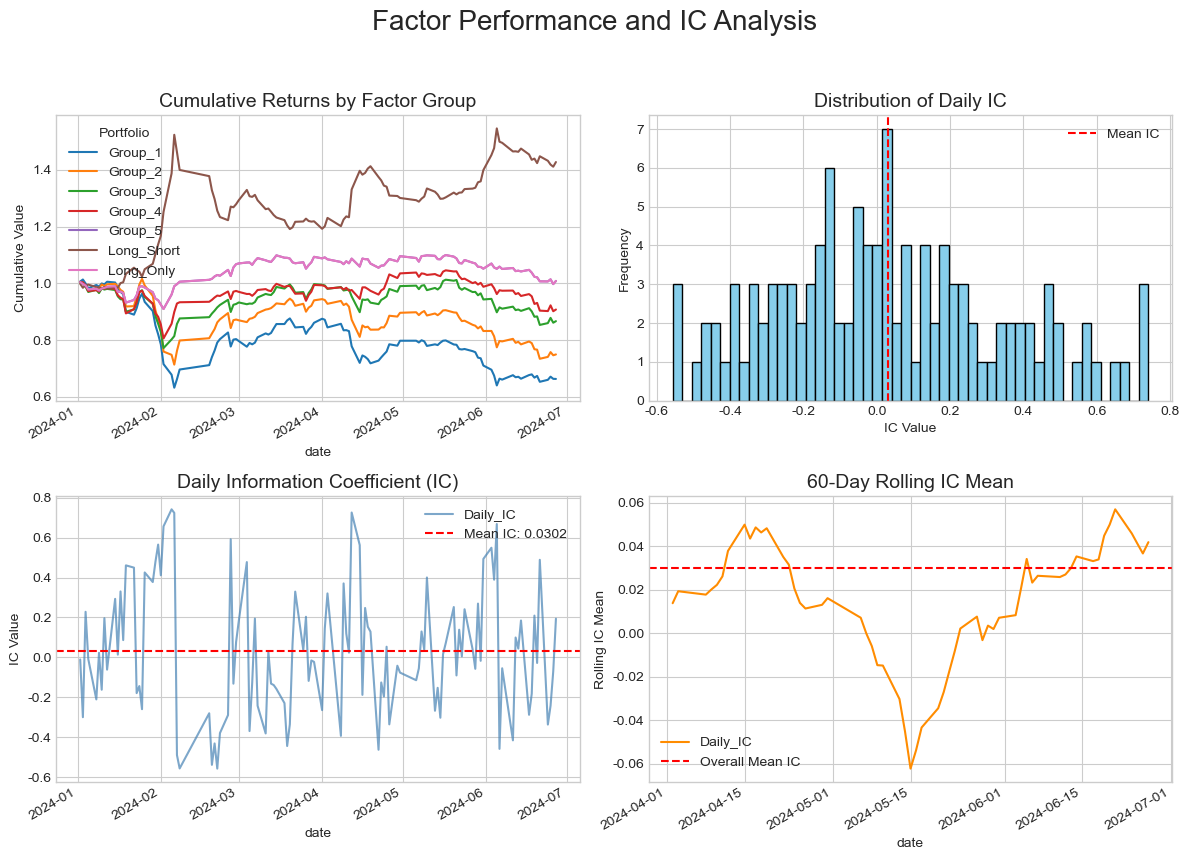

Plotting complete.


In [5]:
if portfolio_returns is not None:
    # 将所有需要的数据传入分析器
    analyzer = PerformanceAnalyzer(portfolio_returns, size_factor_df, master_df)
    
    # 1. 计算各项性能指标
    analyzer.calculate_metrics()
    
    # 2. 绘制图表
    analyzer.plot_results()

### 结论解读

根据输出的图表和指标，我们可以对规模因子在回测期间的表现做出判断：
- **净值曲线 (`Cumulative Returns`)**: `Long_Only`（做多大市值组合）和 `Long_Short`（多空对冲）组合的净值是否长期向上？如果`Long_Short`组合净值持续稳定上升，说明因子具有较好的单调性和选股能力。
- **分组收益 (`Group Cumulative Returns`)**: 从Group 1到Group 5的最终净值是否呈现单调递增或递减的趋势？对于我们`long_direction='high'`的假设，我们期望看到Group 5的收益显著高于其他组，特别是Group 1。
- **IC分析 (`Information Coefficient Analysis`)**: IC代表了因子预测未来收益的能力。IC的均值是否显著大于0？IC的t检验p值是否小于0.05？这些都能量化地告诉我们因子的有效性。

通过这个标准化的流程，我们可以对任何新想到的因子进行快速、严谨的检验。